
- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
    - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    - mostly focused on this approach

- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure


- can do this by
    1. choosing what vars or tuples of vars to split campaigns on
    2. grouping similar buckets w/in those splits
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
- want most variation of rps w/ fewest camapaigns
- dont want to group similar buckets together - think its too complicated


TODO: 2021-05-20
  - test fitting on general traffic sources?
  - test clustering on multiple days of rps data - 
      or rolling rps data or something
  - try out more granular aggs
  - is there some kind of metric which measures total variance
      and computes how much of that variance is captured by a split?

Trevor: 2021-05-21
TODO:
- figure out how to minimize campaign # when writing back to taboola
    - want to make sure campaigns have sufficient traffic
- kw=(location,os,device)
- calc 30-day rps/kw
- can create distribution over the rps(kw) distribution
- 100 campaigns - 1 per percentile

TODO: 2021-05-24
- look into clustering each individual split variable

In [3]:
import sys
import re
import os
# detect if we are running from a `notebooks/*_shared` folder
# re.match("not.*shared",sys.path[0])
if sys.path[0].endswith("_shared"):
    sys.path[0] = "/".join(sys.path[0].split("/")[:-2])
assert sys.path[0].endswith("adtech")

from utils.env import load_env_from_aws
load_env_from_aws()

import pprint
from IPython.display import display as ipydisp    
import collections
import itertools
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models.utils import wavg,get_wavg_by
from notebooks.aduriseti_shared.utils import *

NOW = datetime.datetime.now()
DAY = datetime.timedelta(days=1)

campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

    location_os = ["state", "dma", "operating_system"],
    location_device=["state", "dma", "device", ],
    location_os_device = ["state", "dma", "operating_system","device"],
)

def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

start_date = NOW - 90*DAY
eval_date = NOW - 30*DAY
end_date = NOW

split2aggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(start_date,end_date,None,traffic_source=TABOOLA,agg_columns=tuple(split_cols+["utc_dt"]))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2aggrps[split] = rps_df
    print(split,rps_df.shape)

Attempting to load environ from: `SM_ENV_BASE`
...Success!!
browser ['browser']


INFO:root:query: SELECT browser,utc_dt, COUNT(session_id)                    ... executed in 4.98 seconds
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


browser (94, 11)
operating_system ['operating_system']


INFO:root:query: SELECT operating_system,utc_dt, COUNT(session_id)           ... executed in 4.38 seconds


operating_system (342, 11)
device ['device']


INFO:root:query: SELECT device,utc_dt, COUNT(session_id)                     ... executed in 4.42 seconds


device (199, 11)
product ['product']


INFO:root:query: SELECT product,utc_dt, COUNT(session_id)                    ... executed in 4.25 seconds


product (90, 11)
TOD ['dayofweek', 'hourofday']


INFO:root:query: SELECT dayofweek,hourofday,utc_dt, COUNT(session_id)        ... executed in 4.68 seconds


TOD (4677, 11)
dma ['dma']


INFO:root:query: SELECT dma,utc_dt, COUNT(session_id)                        ... executed in 8.27 seconds


dma (10892, 11)
state ['state']


INFO:root:query: SELECT state,utc_dt, COUNT(session_id)                      ... executed in 4.56 seconds


state (3502, 11)
location ['state', 'dma']


INFO:root:query: SELECT state,dma,utc_dt, COUNT(session_id)                  ... executed in 4.89 seconds


location (13736, 11)
dma_os ['dma', 'operating_system']


INFO:root:query: SELECT dma,operating_system,utc_dt, COUNT(session_id)       ... executed in 4.93 seconds


dma_os (14491, 11)
dma_device ['dma', 'device']


INFO:root:query: SELECT dma,device,utc_dt, COUNT(session_id)                 ... executed in 4.92 seconds


dma_device (12425, 11)
dma_os_device ['dma', 'operating_system', 'device']


INFO:root:query: SELECT dma,operating_system,device,utc_dt, COUNT(session_id)... executed in 4.89 seconds


dma_os_device (14778, 11)
state_os ['state', 'operating_system']


INFO:root:query: SELECT state,operating_system,utc_dt, COUNT(session_id)     ... executed in 4.65 seconds


state_os (6027, 11)
state_device ['state', 'device']


INFO:root:query: SELECT state,device,utc_dt, COUNT(session_id)               ... executed in 4.6 seconds


state_device (4517, 11)
state_os_device ['state', 'operating_system', 'device']


INFO:root:query: SELECT state,operating_system,device,utc_dt, COUNT(session_i... executed in 4.9 seconds


state_os_device (6368, 11)
location_os ['state', 'dma', 'operating_system']


INFO:root:query: SELECT state,dma,operating_system,utc_dt, COUNT(session_id) ... executed in 4.98 seconds


location_os (17485, 11)
location_device ['state', 'dma', 'device']


INFO:root:query: SELECT state,dma,device,utc_dt, COUNT(session_id)           ... executed in 4.93 seconds


location_device (15346, 11)
location_os_device ['state', 'dma', 'operating_system', 'device']


INFO:root:query: SELECT state,dma,operating_system,device,utc_dt, COUNT(sessi... executed in 5.05 seconds


location_os_device (17745, 11)


In [140]:
import sklearn.preprocessing
import sklearn.cluster
import sklearn.tree

from models.utils import wstd
def get_split_factor(rps_df):
    split_attr2unique_vals = {c: rps_df.index.unique(c) for c in rps_df.index.names[:-1]}
    _,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
    return rps_df.reset_index()[[*new_index_order[:-1],"clust"]].drop_duplicates().__len__()

class AggRPSClust:
    def __init__(self,clusts=8):
        self.clusts = clusts
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        self.aggX = X \
            .groupby(X.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(X,"sessions")
            })
        if len(self.aggX) > self.clusts:
            self.aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(self.aggX[["rps"]],sample_weight=self.aggX["sessions"])
        else:
            self.aggX["clust"] = np.arange(len(self.aggX))
        
        return self

    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)
        
class TreeRPSClust:
    def __init__(self,enc_min_cnt=100,min_samples_leaf=30,plot=True):
        self.enc_min_cnt = enc_min_cnt
        self.min_samples_leaf = min_samples_leaf
        self.plot = plot
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        
        Xdf = X .reset_index()[X.index.names]
        ydf = X["rps"]
        wdf = X["sessions"]

        ipydisp(Xdf.isna().sum())
        for c in Xdf.columns:
            too_few_I = Xdf.groupby(c).transform("count").iloc[:,0] < self.enc_min_cnt
            Xdf.loc[too_few_I,c] = np.NaN
        ipydisp(Xdf.isna().sum())
        Xdf = Xdf.iloc[:,:-1]
#         Xdf = Xdf.astype(str).fillna("")

        self.enc_1hot = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore") .fit(Xdf)
        self.enc_features = [*self.enc_1hot.get_feature_names()]
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        y = ydf.fillna(0)
        w = wdf

        self.clf = sklearn.tree.DecisionTreeRegressor(
                            min_samples_leaf=self.min_samples_leaf) \
                        .fit(X,y,sample_weight=wdf)
        print(sklearn.tree.export_text(self.clf,feature_names=self.enc_features))
        
        yhat = self.clf.predict(X)
        print("Tree RPS MAE:",(y - yhat).abs().mean())

        return self
        
    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        Xdf = X .reset_index()[X.index.names].iloc[:,:-1]
#         X = self.enc_1hot.transform(Xdf.astype(str).fillna(""))
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        return self.clf.apply(X)
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

class KpiCorrClust:
    def __init__(self,clusts=8,kpis=["rps","score","lps","rpl"],plot=True):
        self.clusts = clusts
        self.kpis = kpis
        self.plot = plot
        
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        
        aggX = X.groupby(X.index.names[:-1]) \
            [["sessions","revenue"]].sum()
        aggX[self.kpis] = X.groupby(X.index.names[:-1]) \
            .apply(lambda df: wavg(df[self.kpis],df["sessions"]))
        buckets = aggX.index.values

        min_date = X.index.unique("utc_dt").min()
        max_date = X.index.unique("utc_dt").max()
        date_range = pd.date_range(min_date,max_date)
        kpi_tensor = np.stack(X.loc[bucket,self.kpis] \
                                  .reindex(date_range).fillna(0) \
                                  .rolling(7).mean().fillna(0)
                              for bucket in buckets)
        kpi_tensor = kpi_tensor.transpose(2,0,1)
        D, H, W = kpi_tensor.shape
        kpi_tensor.shape

        if self.plot:
            # i = (kpi_tensor > 0).sum(axis=1)[:,0].argmax()
            # i = kpi_tensor.sum(axis=2)[0,:].argmax()
            i = (kpi_tensor > 1e-3).sum(axis=2)[0].argmax()
            plt.plot(kpi_tensor[0,i,:])
            plt.show()

        kpi_sqrt_tensor = kpi_tensor ** 0.5
        kpi_corps = (kpi_sqrt_tensor @ kpi_sqrt_tensor.transpose(0, 2, 1))
        kpi_coprs = np.log(kpi_corps)
        # kpi_corps = kpi_corps / kpi_corps.max(axis=2).max(axis=1).reshape(D,1,1)
        kpi_corps_df = pd.DataFrame(kpi_corps.mean(axis=0), columns=buckets, index=buckets)

        if len(aggX) > self.clusts:
            aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(kpi_corps_df.values,sample_weight=aggX["sessions"])
        else:
            aggX["clust"] = np.arange(len(aggX))
        self.aggX = aggX
        
#         if plot:
#             for ci in range(CLUSTS):
#                 clust_kpi_df = pd.concat(kpi_df.loc[tuple(uval)] for uval in col_uvals[clust==ci]) \
#                     .reset_index()
#                 print(ci,"rps:",wavg(clust_kpi_df["rps"],clust_kpi_df["sessions"]))
#                 ipydisp(clust_kpi_df[["sessions",'revenue']].sum())
#                 clust_kpi_df \
#                     .groupby("utc_dt")["rps"] \
#                     .agg(get_wavg_by(clust_kpi_df,"sessions")) \
#                     .reindex(pd.date_range(eval_date-7*DAY,end_date)) \
#                     .fillna(0).rolling(7).mean() \
#                     .plot(label=ci,figsize=(15,5))
#             plt.legend()
#             plt.show()
        
        return self
        
    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

class HybridCorrTreeClust:
    def __init__(
            self,
            enc_min_cnt=100,min_samples_leaf=30,
            clusts=8,kpis=["rps","score","lps","rpl"],
            plot=True):
        self.enc_min_cnt = enc_min_cnt
        self.min_samples_leaf = min_samples_leaf
        self.clusts = clusts
        self.kpis = kpis
        self.plot = plot
        
    def fit(self,X,_):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        self.splitcol2clusterer = {}
        for c in split_idx:
            aggX = X.groupby([c,"utc_dt"]) [["sessions","revenue"]].sum()
            aggX[kpis] = X.groupby([c,"utc_dt"]) \
                .apply(lambda df: wavg(df[kpis],df["sessions"]))
            clusterer = KpiCorrClust(plot=False) .fit(aggX,None)
            clust = clusterer \
                .transform(X.reset_index().set_index([c,"utc_dt"]))
            self.splitcol2clusterer[c] = clusterer
            X[f"{c}_clust"] = clust.values
        
        clust_idx = [f"{c}_clust" for c in split_idx]
#         Xclust = X.groupby([*clust_idx,"utc_dt"]) \
#             [["sessions","revenue"]].sum()
#         Xclust[kpis] = X.groupby([*clust_idx,"utc_dt"]) \
#             .apply(lambda df: wavg(df[kpis],df["sessions"]))

        self.tree_clusterer = TreeRPSClust(plot=False) \
            .fit(X.reset_index().set_index([*clust_idx,"utc_dt"]),None)
        # clusterer = TreeRPSClust() \
        #     .fit(Xclust,None)

        return self
    
    def transform(self,X):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        clust_idx = [f"{c}_clust" for c in split_idx]
        for c,d in zip(split_idx,clust_idx):
            X[d] = self.splitcol2clusterer[c] \
                .transform(X.reset_index().set_index([c,"utc_dt"])) \
                .values
        return self.tree_clusterer \
            .transform(X.reset_index().set_index([*clust_idx,"utc_dt"]))
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

{'clust_mtd': 'AggRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.007594691466081629,
 'clustered_split_factor': 2,
 'clusterer': <__main__.AggRPSClust object at 0x7fd66e290bb0>,
 'fit_shape': (2, 2),
 'split': 'browser',
 'split_variance': 0.007594691466081629}


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,7,0.000000
1,27572,0.476766


browser    0
utc_dt     0
dtype: int64

browser    64
utc_dt     64
dtype: int64

|X| (64, 1)
|--- value: [0.41]

Tree RPS MAE: 0.20281007503862677
|X| (64, 1)
|X| (30, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd644f3a5e0>,
 'fit_shape': (2, 2),
 'split': 'browser',
 'split_variance': 0.007594691466081629}


,sessions,rps
clust,,
0,27579,0.476645


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


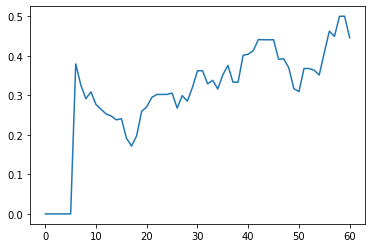

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.007594691466081629,
 'clustered_split_factor': 2,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd644f3a130>,
 'fit_shape': (2, 2),
 'split': 'browser',
 'split_variance': 0.007594691466081629}


,sessions,rps
clust,,
0,7,0.000000
1,27572,0.476766


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


browser_clust    0
utc_dt           0
dtype: int64

browser_clust    64
utc_dt           64
dtype: int64

|X| (64, 1)
|--- value: [0.41]

Tree RPS MAE: 0.20281007503862677
|X| (64, 1)
|X| (30, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd64541fbe0>,
 'fit_shape': (2, 2),
 'split': 'browser',
 'split_variance': 0.007594691466081629}


<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,27579,0.476645


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (6, 2),
 'cluster_variance': 0.07666109531637397,
 'clustered_split_factor': 6,
 'clusterer': <__main__.AggRPSClust object at 0x7fd64541fa90>,
 'fit_shape': (6, 2),
 'split': 'operating_system',
 'split_variance': 0.07666109531637397}


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,14,0.000000
1,938,0.219307
2,1317,0.383819
3,24862,0.498658
4,316,0.023259
5,131,0.223053


operating_system    0
utc_dt              0
dtype: int64

operating_system    218
utc_dt              218
dtype: int64

|X| (218, 1)
|--- value: [0.41]

Tree RPS MAE: 0.37715970567909923
|X| (218, 1)
|X| (124, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd646d95970>,
 'fit_shape': (6, 2),
 'split': 'operating_system',
 'split_variance': 0.07666109531637397}


,sessions,rps
clust,,
0,27578,0.476663


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


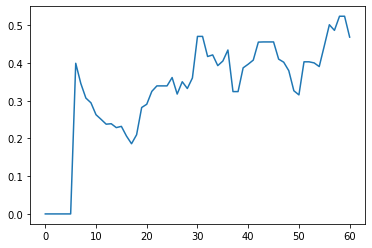

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (6, 2),
 'cluster_variance': 0.07666109531637397,
 'clustered_split_factor': 6,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd645d0e2b0>,
 'fit_shape': (6, 2),
 'split': 'operating_system',
 'split_variance': 0.07666109531637397}


,sessions,rps
clust,,
0,14,0.000000
1,938,0.219307
2,1317,0.383819
3,24862,0.498658
4,316,0.023259
5,131,0.223053


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


operating_system_clust    0
utc_dt                    0
dtype: int64

operating_system_clust    218
utc_dt                    218
dtype: int64

|X| (218, 1)
|--- value: [0.41]

Tree RPS MAE: 0.37715970567909923
|X| (218, 1)
|X| (124, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd66d906220>,
 'fit_shape': (6, 2),
 'split': 'operating_system',
 'split_variance': 0.07666109531637397}


<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,27578,0.476663


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.08044148756319433,
 'clustered_split_factor': 3,
 'clusterer': <__main__.AggRPSClust object at 0x7fd644d6da30>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.08044148756319433}


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,26462,0.493148
1,729,0.069849
2,388,0.115464


device    0
utc_dt    0
dtype: int64

device    140
utc_dt    140
dtype: int64

|X| (140, 1)
|--- value: [0.41]

Tree RPS MAE: 0.32842774816367654
|X| (140, 1)
|X| (59, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd6466cbc40>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.08044148756319433}


,sessions,rps
clust,,
0,27579,0.476645


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


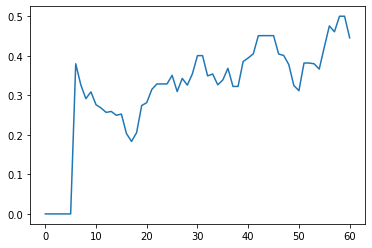

{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.08044148756319433,
 'clustered_split_factor': 3,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd66d906550>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.08044148756319433}


<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,26462,0.493148
1,729,0.069849
2,388,0.115464


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


device_clust    0
utc_dt          0
dtype: int64

device_clust    140
utc_dt          140
dtype: int64

|X| (140, 1)
|--- value: [0.41]

Tree RPS MAE: 0.32842774816367654
|X| (140, 1)
|X| (59, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd6467fe7f0>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.08044148756319433}


<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,27579,0.476645


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.0028702112783241147,
 'clustered_split_factor': 2,
 'clusterer': <__main__.AggRPSClust object at 0x7fd645ca16d0>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.0028702112783241147}


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,1,0.000000
1,27578,0.476663


product    0
utc_dt     0
dtype: int64

product    62
utc_dt     62
dtype: int64

|X| (62, 1)
|--- value: [0.41]

Tree RPS MAE: 0.19611897949765236
|X| (62, 1)
|X| (28, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd6468b2640>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.0028702112783241147}


,sessions,rps
clust,,
0,27579,0.476645


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


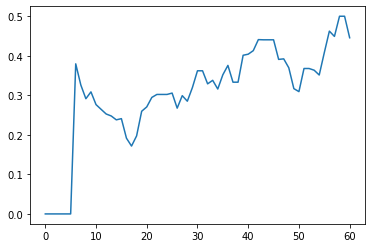

{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.0028702112783241147,
 'clustered_split_factor': 2,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd644ef21f0>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.0028702112783241147}


<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,1,0.000000
1,27578,0.476663


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


product_clust    0
utc_dt           0
dtype: int64

product_clust    62
utc_dt           62
dtype: int64

|X| (62, 1)
|--- value: [0.41]

Tree RPS MAE: 0.19611897949765236
|X| (62, 1)
|X| (28, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd645f509a0>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.0028702112783241147}


<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,27579,0.476645


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.04047759410837303,
 'clustered_split_factor': 46,
 'clusterer': <__main__.AggRPSClust object at 0x7fd6467fe7c0>,
 'fit_shape': (553, 2),
 'split': 'TOD',
 'split_variance': 0.35348438281973343}


,sessions,rps
clust,,
0.0,1655,0.498123
1.0,7685,0.515878
2.0,6,0.000000
4.0,4959,0.430673
5.0,474,0.267975
6.0,5064,0.472909
7.0,7729,0.478580


dayofweek    0
hourofday    0
utc_dt       0
dtype: int64

dayofweek       0
hourofday    3190
utc_dt       2443
dtype: int64

|X| (3190, 8)
|--- x0_5.0 <= 0.50
|   |--- x0_4.0 <= 0.50
|   |   |--- x0_0.0 <= 0.50
|   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |   |   |--- value: [0.38]
|   |   |   |   |   |--- x0_1.0 >  0.50
|   |   |   |   |   |   |--- value: [0.39]
|   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |--- value: [0.38]
|   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |--- value: [0.26]
|   |   |--- x0_0.0 >  0.50
|   |   |   |--- value: [0.21]
|   |--- x0_4.0 >  0.50
|   |   |--- value: [0.47]
|--- x0_5.0 >  0.50
|   |--- value: [0.49]

Tree RPS MAE: 0.5387519778367247
|X| (3190, 8)
|X| (1487, 8)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.05664331140115261,
 'clustered_split_factor': 7,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd66d7d0af0>,
 'fit_shape': (553, 2),
 'split': 'TOD',
 'split_variance': 0.35348438281973343}


,sessions,rps
clust,,
6,6913,0.489132
7,5538,0.549734
8,6333,0.437773
9,414,0.197971
10,421,0.297363
11,3801,0.487264
12,4159,0.453942


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


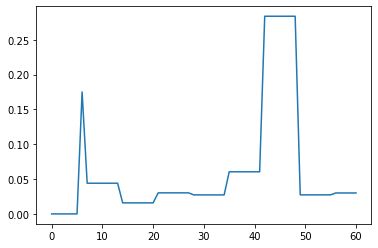

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.05286155661494798,
 'clustered_split_factor': 46,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd66e1d41f0>,
 'fit_shape': (553, 2),
 'split': 'TOD',
 'split_variance': 0.35348438281973343}


,sessions,rps
clust,,
0.0,3866,0.452514
1.0,4806,0.481373
2.0,2325,0.418058
3.0,4599,0.483025
4.0,3477,0.503786
5.0,2131,0.356336
6.0,4682,0.559269
7.0,1686,0.450516


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

dayofweek_clust    0
hourofday_clust    0
utc_dt             0
dtype: int64

dayofweek_clust       0
hourofday_clust       0
utc_dt             2443
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (3190, 15)
|--- x1_2.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- x1_5.0 <= 0.50
|   |   |   |--- x1_7.0 <= 0.50
|   |   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |   |--- x1_6.0 <= 0.50
|   |   |   |   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_3.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- x0_3.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_3.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.36]
|   |   |   |   |   |   |   |   |   |   |--- x1_3.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.36]
|   |   |   |   |   |   |   |

,sessions,rps
clust,,
13,666,0.300105
14,1005,0.442930
16,990,0.514833
17,901,0.666837
19,476,0.366450
20,732,0.455191
22,1187,0.569380
23,770,0.481025
24,88,0.184545


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.06892867442149542,
 'clustered_split_factor': 8,
 'clusterer': <__main__.AggRPSClust object at 0x7fd64541f430>,
 'fit_shape': (209, 2),
 'split': 'dma',
 'split_variance': 0.31978274672757945}


,sessions,rps
clust,,
0,8560,0.396791
1,1098,0.593346
2,14,0.000000
3,3318,0.583024
4,193,0.332746
5,4564,0.456707
6,7338,0.521784
7,2494,0.475308


dma       0
utc_dt    0
dtype: int64

dma       7233
utc_dt    7233
dtype: int64

|X| (7233, 1)
|--- value: [0.41]

Tree RPS MAE: 0.6813227716185178
|X| (7233, 1)
|X| (3659, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd6477d7c10>,
 'fit_shape': (209, 2),
 'split': 'dma',
 'split_variance': 0.31978274672757945}


,sessions,rps
clust,,
0,27579,0.476645


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


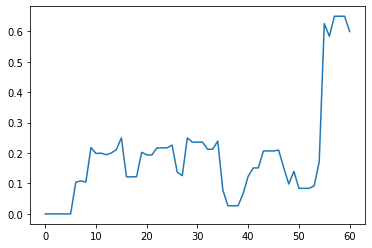

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.07734702208378576,
 'clustered_split_factor': 8,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd6477d7af0>,
 'fit_shape': (209, 2),
 'split': 'dma',
 'split_variance': 0.31978274672757945}


,sessions,rps
clust,,
0,4144,0.393061
1,1529,0.590912
2,3316,0.463314
3,4719,0.452478
4,2348,0.359549
5,2849,0.594270
6,2588,0.413540
7,6086,0.547801


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


dma_clust    0
utc_dt       0
dtype: int64

dma_clust      0
utc_dt       256
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (7233, 8)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x0_2.0 <= 0.50
|   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |--- value: [0.50]
|   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |--- value: [0.50]
|   |   |   |   |   |--- x0_1.0 >  0.50
|   |   |   |   |   |   |--- value: [0.51]
|   |   |   |   |--- x0_7.0 >  0.50
|   |   |   |   |   |--- value: [0.42]
|   |   |   |--- x0_4.0 >  0.50
|   |   |   |   |--- value: [0.43]
|   |   |--- x0_2.0 >  0.50
|   |   |   |--- value: [0.59]
|   |--- x0_6.0 >  0.50
|   |   |--- value: [0.26]
|--- x0_0.0 >  0.50
|   |--- value: [0.14]

Tree RPS MAE: 0.6049770250916268
|X| (7233, 8)
|X| (3659, 8)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.07495746996680414,
 'clustered_split_factor': 8,
 'clusterer': <__main__.HybridCorrTreeClust object 

,sessions,rps
clust,,
7,2105,0.403445
8,2111,0.382725
9,3570,0.436593
10,1740,0.434322
11,6086,0.547801
12,4378,0.593097
13,4273,0.399488
14,3316,0.463314


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.11621731953671499,
 'clustered_split_factor': 8,
 'clusterer': <__main__.AggRPSClust object at 0x7fd646301c10>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.1948777115330318}


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,4492,0.341951
1,5624,0.481976
2,125,0.267200
3,5797,0.363630
4,4844,0.664922
5,3321,0.515554
6,110,0.968727
7,3266,0.525953


state     0
utc_dt    0
dtype: int64

state     2333
utc_dt    2333
dtype: int64

|X| (2333, 1)
|--- value: [0.41]

Tree RPS MAE: 0.5480843548035778
|X| (2333, 1)
|X| (1169, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd654274cd0>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.1948777115330318}


,sessions,rps
clust,,
0,27579,0.476645


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


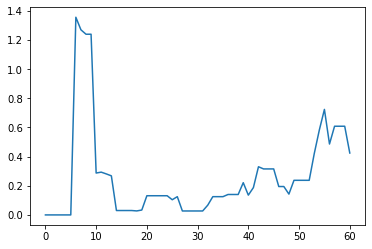

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.09890245647550894,
 'clustered_split_factor': 8,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd6468b2730>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.1948777115330318}


,sessions,rps
clust,,
0,1500,0.265713
1,3127,0.493660
2,4694,0.486296
3,4455,0.317512
4,2634,0.601686
5,2639,0.595060
6,6268,0.503033
7,2262,0.529509


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust    0
utc_dt         0
dtype: int64

state_clust      52
utc_dt         2333
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (2333, 8)
|--- x0_3.0 <= 0.50
|   |--- x0_1.0 <= 0.50
|   |   |--- x0_nan <= 0.50
|   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |--- value: [0.48]
|   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |--- value: [0.50]
|   |   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |   |--- value: [0.47]
|   |   |   |   |--- x0_0.0 >  0.50
|   |   |   |   |   |--- value: [0.40]
|   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |--- value: [0.36]
|   |   |--- x0_nan >  0.50
|   |   |   |--- value: [0.66]
|   |--- x0_1.0 >  0.50
|   |   |--- value: [0.18]
|--- x0_3.0 >  0.50
|   |--- value: [0.24]

Tree RPS MAE: 0.49881896221713334
|X| (2333, 8)
|X| (1169, 8)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.09798328936476315,
 'clustered_split_factor': 7,
 'clusterer': <__main__.HybridCorrTreeClust object

,sessions,rps
clust,,
7,7628,0.536971
8,1827,0.538210
9,5968,0.490032
10,3866,0.485428
11,2335,0.621762
13,1500,0.265713
14,4455,0.317512


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.07398717224255937,
 'clustered_split_factor': 177,
 'clusterer': <__main__.AggRPSClust object at 0x7fd6464201f0>,
 'fit_shape': (342, 2),
 'split': 'location',
 'split_variance': 0.44253845497584}


,sessions,rps
clust,,
0.0,7019,0.432012
1.0,296,0.415777
2.0,46,0.124783
3.0,2643,0.566220
4.0,2890,0.435893
5.0,7368,0.411383
6.0,1007,0.635396
7.0,6304,0.563355


state     0
dma       0
utc_dt    0
dtype: int64

state     1323
dma       8805
utc_dt     268
dtype: int64

|X| (9102, 37)
|--- x0_TX <= 0.50
|   |--- x0_WY <= 0.50
|   |   |--- x0_nan <= 0.50
|   |   |   |--- x0_NY <= 0.50
|   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |--- x0_MI <= 0.50
|   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |--- x0_KY <= 0.50
|   |   |   |   |   |   |   |   |--- x0_IA <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_CA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_OR <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 24
|   |   |   |   |   |   |   |   |   |   |--- x0_OR >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.19]
|   |   |   |   |   |   |   |   |   |--- x0_CA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.29]
|   |   |   |   |   |   |   |   |--- x0_IA >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.20]
|   |   |   |   |   |   |   |--- x0_KY >  0.50
|   |   |   |   |   |   |   |   |--- x1_nan <= 0.50
|   |   |   |   |   |   |   |   |   

,sessions,rps
clust,,
16,17558,0.498533
17,574,0.747448
18,256,0.462227
61,797,0.499561
63,776,0.526495
64,225,0.368222
65,831,0.190568
66,425,0.425082
68,555,0.502541


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


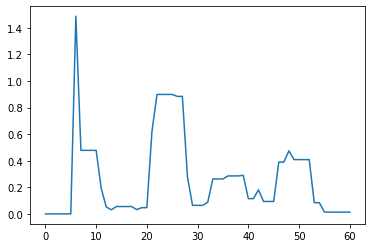

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.0711977276080027,
 'clustered_split_factor': 157,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd645e2b5e0>,
 'fit_shape': (342, 2),
 'split': 'location',
 'split_variance': 0.44253845497584}


,sessions,rps
clust,,
0.0,2368,0.455886
1.0,4915,0.407932
2.0,3065,0.554934
3.0,3663,0.582202
4.0,2926,0.498092
5.0,4270,0.505880
6.0,4005,0.454082
7.0,2361,0.332714


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

state_clust    0
dma_clust      0
utc_dt         0
dtype: int64

state_clust      0
dma_clust        0
utc_dt         268
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (9102, 16)
|--- x1_2.0 <= 0.50
|   |--- x0_7.0 <= 0.50
|   |   |--- x0_0.0 <= 0.50
|   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |   |--- x1_7.0 <= 0.50
|   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_3.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_3.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- x1_3.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.32]
|   |   |   |   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.43]
|   |   |   |   |   |   |   |

,sessions,rps
clust,,
13,1404,0.632218
15,2240,0.621754
16,1855,0.514814
18,200,0.350744
19,124,0.272339
22,405,0.673457
23,682,0.198402
24,875,0.414551
26,1190,0.485749


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.083829651219497,
 'clustered_split_factor': 31,
 'clusterer': <__main__.AggRPSClust object at 0x7fd66e265190>,
 'fit_shape': (703, 2),
 'split': 'dma_os',
 'split_variance': 0.537976346328981}


,sessions,rps
clust,,
0.0,1,0.000000
1.0,10314,0.429926
2.0,2,0.000000
3.0,265,0.266906
4.0,6314,0.410457
5.0,2948,0.525123
6.0,57,0.000000
7.0,7439,0.598183


dma                 0
operating_system    0
utc_dt              0
dtype: int64

dma                 8809
operating_system     974
utc_dt              9257
dtype: int64

|X| (9257, 8)
|--- x1_Windows <= 0.50
|   |--- x0_602 <= 0.50
|   |   |--- x0_nan <= 0.50
|   |   |   |--- x1_Linux <= 0.50
|   |   |   |   |--- x0_504 <= 0.50
|   |   |   |   |   |--- x0_511 <= 0.50
|   |   |   |   |   |   |--- value: [0.11]
|   |   |   |   |   |--- x0_511 >  0.50
|   |   |   |   |   |   |--- value: [0.10]
|   |   |   |   |--- x0_504 >  0.50
|   |   |   |   |   |--- value: [0.23]
|   |   |   |--- x1_Linux >  0.50
|   |   |   |   |--- x0_511 <= 0.50
|   |   |   |   |   |--- value: [0.06]
|   |   |   |   |--- x0_511 >  0.50
|   |   |   |   |   |--- value: [0.00]
|   |   |--- x0_nan >  0.50
|   |   |   |--- x1_nan <= 0.50
|   |   |   |   |--- value: [0.17]
|   |   |   |--- x1_nan >  0.50
|   |   |   |   |--- value: [0.25]
|   |--- x0_602 >  0.50
|   |   |--- value: [0.48]
|--- x1_Windows >  0.50
|   |--- x0_501 <= 0.50
|   |   |--- x0_504 <= 0.50
|   |   |   |--- x0_nan <= 0.50
|   |   |   |   |--- x0_511 <= 0.50
|   |   |   |   |   |--- value: [0.59]
|   |   |   |   |--

,sessions,rps
clust,,
6,1604,0.268834
7,62,1.588226
8,78,0.158718
10,849,0.242297
11,62,0.000000
15,61,0.000000
20,22320,0.492085
21,796,0.585986
23,692,0.698966


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


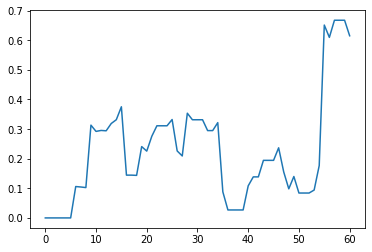

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.10200363729455622,
 'clustered_split_factor': 23,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd64642ac70>,
 'fit_shape': (703, 2),
 'split': 'dma_os',
 'split_variance': 0.537976346328981}


,sessions,rps
clust,,
0.0,2942,0.329324
1.0,2400,0.393380
2.0,5389,0.597947
3.0,2776,0.464742
4.0,2664,0.431742
5.0,3451,0.469828
6.0,3807,0.382523
7.0,3911,0.624219


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

dma_clust                 0
operating_system_clust    0
utc_dt                    0
dtype: int64

dma_clust                   0
operating_system_clust     43
utc_dt                    269
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (9257, 13)
|--- x0_3.0 <= 0.50
|   |--- x1_3.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |--- x1_2.0 <= 0.50
|   |   |   |   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |   |   |--- x0_7.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.02]
|   |   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |--- x0_0.0 >  0.50
|   |   |   |   |   |   |   |--- value: [0.07]
|   |   |   |   |   |--- x1_2.0 >  0.50
|   |   |   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_5.0 <= 0.50
| 

,sessions,rps
clust,,
9,92,0.242935
11,85,0.142706
12,84,0.000000
13,82,0.437561
14,110,0.305455
18,112,0.338482
19,154,0.301558
20,68,0.000000
21,115,0.362261


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.08896730190101927,
 'clustered_split_factor': 18,
 'clusterer': <__main__.AggRPSClust object at 0x7fd64541f8b0>,
 'fit_shape': (450, 2),
 'split': 'dma_device',
 'split_variance': 0.39992498737222787}


,sessions,rps
clust,,
0.0,203,0.316355
1.0,5764,0.401262
2.0,2,0.000000
3.0,2,0.000000
4.0,8468,0.592636
5.0,3397,0.539980
6.0,13,0.000000
7.0,9647,0.405883


dma       0
device    0
utc_dt    0
dtype: int64

dma       8203
device    8203
utc_dt    8203
dtype: int64

|X| (8203, 2)
|--- value: [0.41]

Tree RPS MAE: 0.678438878623825
|X| (8203, 2)
|X| (4222, 2)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 3,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd66e299d90>,
 'fit_shape': (450, 2),
 'split': 'dma_device',
 'split_variance': 0.39992498737222787}


,sessions,rps
clust,,
0,27579,0.476645


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


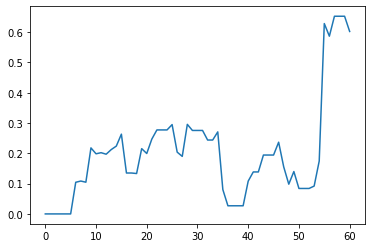

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.10034104578302558,
 'clustered_split_factor': 14,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd66deff4c0>,
 'fit_shape': (450, 2),
 'split': 'dma_device',
 'split_variance': 0.39992498737222787}


,sessions,rps
clust,,
0.0,2495,0.321054
1.0,5789,0.570160
2.0,2316,0.501265
3.0,2957,0.467377
4.0,4138,0.625471
5.0,2359,0.397389
6.0,3854,0.441268
7.0,3588,0.355202


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

dma_clust       0
device_clust    0
utc_dt          0
dtype: int64

dma_clust         0
device_clust      0
utc_dt          258
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (8203, 11)
|--- x0_2.0 <= 0.50
|   |--- x0_0.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.35]
|   |   |   |   |   |   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.31]
|   |   |   |   |   |   |--- x0_1.0 >  0.50
|   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |--- value: [0.13]
|   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.15]
|   |   |   |   |   |--- x0_7.0 >  0.50
|   |   |   |   |   |   |--- value: [0.02]
|   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |--- value: [0.46]


,sessions,rps
clust,,
8,113,0.074159
10,75,0.000000
11,166,0.000000
13,114,0.159825
14,183,0.082186
15,118,0.127119
16,130,0.024615
21,5789,0.570160
22,3553,0.440107


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.08846572897648916,
 'clustered_split_factor': 53,
 'clusterer': <__main__.AggRPSClust object at 0x7fd644d7dd30>,
 'fit_shape': (926, 2),
 'split': 'dma_os_device',
 'split_variance': 0.5740837879536181}


,sessions,rps
clust,,
0.0,5664,0.424319
2.0,267,0.264906
3.0,1,0.000000
4.0,3289,0.544449
5.0,60,0.000000
6.0,7808,0.598172
7.0,10067,0.412429


dma                 0
operating_system    0
device              0
utc_dt              0
dtype: int64

dma                 8891
operating_system     980
device               199
utc_dt              9394
dtype: int64

|X| (9394, 11)
|--- x1_Windows <= 0.50
|   |--- x0_602 <= 0.50
|   |   |--- x0_nan <= 0.50
|   |   |   |--- x1_nan <= 0.50
|   |   |   |   |--- x0_504 <= 0.50
|   |   |   |   |   |--- x0_511 <= 0.50
|   |   |   |   |   |   |--- value: [0.05]
|   |   |   |   |   |--- x0_511 >  0.50
|   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |--- x0_504 >  0.50
|   |   |   |   |   |--- value: [0.09]
|   |   |   |--- x1_nan >  0.50
|   |   |   |   |--- x2_DESK <= 0.50
|   |   |   |   |   |--- value: [0.61]
|   |   |   |   |--- x2_DESK >  0.50
|   |   |   |   |   |--- x0_511 <= 0.50
|   |   |   |   |   |   |--- value: [0.08]
|   |   |   |   |   |--- x0_511 >  0.50
|   |   |   |   |   |   |--- value: [0.00]
|   |   |--- x0_nan >  0.50
|   |   |   |--- x2_nan <= 0.50
|   |   |   |   |--- x1_nan <= 0.50
|   |   |   |   |   |--- x2_PHON <= 0.50
|   |   |   |   |   |   |--- value: [0.08]
|   |   |   |   |   |--- x2_PHON >  0.50
|   |   |   |   |   |   |--- value: [0.21]
|   |   |   |   |--- x1_n

,sessions,rps
clust,,
6,2418,0.260608
7,124,0.794113
8,113,0.169469
23,61,0.000000
28,22616,0.495379
29,500,0.492584
31,692,0.698966
32,1054,0.440375


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


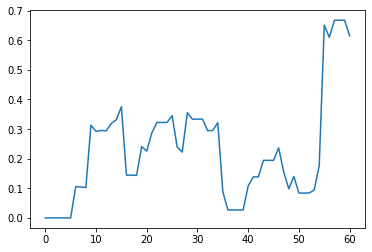

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.09954769355403018,
 'clustered_split_factor': 38,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd67b69dbb0>,
 'fit_shape': (926, 2),
 'split': 'dma_os_device',
 'split_variance': 0.5740837879536181}


,sessions,rps
clust,,
0.0,2133,0.419156
1.0,4066,0.354388
2.0,5388,0.598058
3.0,4768,0.403241
4.0,3909,0.624538
5.0,3021,0.475993
6.0,1706,0.497205
7.0,2165,0.406324


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

dma_clust                 0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

dma_clust                   0
operating_system_clust     43
device_clust                0
utc_dt                    271
dtype: int64

|X| (9394, 16)
|--- x0_4.0 <= 0.50
|   |--- x0_0.0 <= 0.50
|   |   |--- x1_3.0 <= 0.50
|   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |   |   |   |--- x2_1.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_3.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.14]
|   |   |   |   |   |   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.15]
|   |   |   |   |   |   |   |   |--- x0_3.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.18]
|   |   |   |   |   |   |   |--- x2_1.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.26]
|   |   |   |   |   |   |--- x0_1.0 >  0.50
|   |   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |   |--- value: [0.33]
|   |   |   |   |   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |   |   |   |   |-

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (35, 2),
 'cluster_variance': 0.14090001633374782,
 'clustered_split_factor': 89,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd646511310>,
 'fit_shape': (926, 2),
 'split': 'dma_os_device',
 'split_variance': 0.5740837879536181}


,sessions,rps
clust,,
10,237,0.635485
11,131,0.354504
12,127,0.446142
13,109,0.000000
15,394,0.202259
16,71,0.000000
20,88,0.137841
22,54,0.000000
23,19,0.000000


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.12217006179857268,
 'clustered_split_factor': 28,
 'clusterer': <__main__.AggRPSClust object at 0x7fd66df49460>,
 'fit_shape': (235, 2),
 'split': 'state_os',
 'split_variance': 0.338481785145715}


,sessions,rps
clust,,
0.0,2076,0.298565
1.0,52,0.000000
2.0,10848,0.546230
3.0,2,0.000000
4.0,41,0.000000
5.0,9400,0.357206
6.0,4773,0.645619
7.0,301,0.464983


state               0
operating_system    0
utc_dt              0
dtype: int64

state               3000
operating_system     172
utc_dt              3777
dtype: int64

|X| (3777, 12)
|--- x0_TX <= 0.50
|   |--- x1_Windows <= 0.50
|   |   |--- x0_IL <= 0.50
|   |   |   |--- x1_Mac OS X <= 0.50
|   |   |   |   |--- x0_VA <= 0.50
|   |   |   |   |   |--- x0_PA <= 0.50
|   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |--- x0_nan <= 0.50
|   |   |   |   |   |   |   |   |--- x0_NY <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.05]
|   |   |   |   |   |   |   |   |--- x0_NY >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.04]
|   |   |   |   |   |   |   |--- x0_nan >  0.50
|   |   |   |   |   |   |   |   |--- x1_Linux <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.04]
|   |   |   |   |   |   |   |   |--- x1_Linux >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.13]
|   |   |   |   |   |   |--- x0_GA >  0.50
|   |   |   |   |   |   |   |--- value: [0.22]
|   |   |   |   |   |--- x0_PA >  0.50
|   |   |   |   |   |   |--- value: [0.24]
|   |   |   |   |--- x0_VA >  0.50
|   |   |   |   |   |---

,sessions,rps
clust,,
9,956,0.239801
10,42,0.000000
14,60,0.139667
15,87,0.000000
16,67,0.000000
19,1105,0.225665
21,58,2.582241
22,80,0.000000
29,17542,0.470746


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


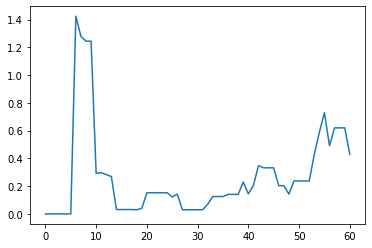

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.13038435821858899,
 'clustered_split_factor': 18,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd646967f10>,
 'fit_shape': (235, 2),
 'split': 'state_os',
 'split_variance': 0.338481785145715}


,sessions,rps
clust,,
0.0,2449,0.292740
1.0,4424,0.514849
2.0,4124,0.300057
3.0,6034,0.569682
4.0,1516,0.266985
5.0,2373,0.621083
6.0,2862,0.644631
7.0,3711,0.466595


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

state_clust               0
operating_system_clust    0
utc_dt                    0
dtype: int64

state_clust                  0
operating_system_clust      43
utc_dt                    2668
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (3777, 13)
|--- x0_7.0 <= 0.50
|   |--- x0_0.0 <= 0.50
|   |   |--- x1_3.0 <= 0.50
|   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |--- x1_2.0 <= 0.50
|   |   |   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_3.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |   |   |--- x0_3.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.04]
|   |   |   |   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |   |   |   |--- value: [0.07]
|   |   |   |   |   |--- x0_1.0 >  0.50
|   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |--- value: [0.16]
|  

,sessions,rps
clust,,
8,137,0.000000
11,134,0.050522
12,81,0.057407
13,78,1.133077
14,71,0.133099
16,296,0.130980
17,73,0.000000
21,234,0.454530
22,59,0.637627


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.13856892714059701,
 'clustered_split_factor': 17,
 'clusterer': <__main__.AggRPSClust object at 0x7fd6468d66d0>,
 'fit_shape': (141, 2),
 'split': 'state_device',
 'split_variance': 0.2320334799252437}


,sessions,rps
clust,,
0.0,1096,0.144881
1.0,4789,0.701821
2.0,5614,0.547345
3.0,18,0.000000
4.0,271,0.516458
5.0,5716,0.368783
6.0,5883,0.482362
7.0,4187,0.350402


state     0
device    0
utc_dt    0
dtype: int64

state     3009
device    3009
utc_dt    3009
dtype: int64

|X| (3009, 2)
|--- value: [0.41]

Tree RPS MAE: 0.5449215015605279
|X| (3009, 2)
|X| (1508, 2)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 3,
 'clusterer': <__main__.TreeRPSClust object at 0x7fd6468fc3a0>,
 'fit_shape': (141, 2),
 'split': 'state_device',
 'split_variance': 0.2320334799252437}


,sessions,rps
clust,,
0,27579,0.476645


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


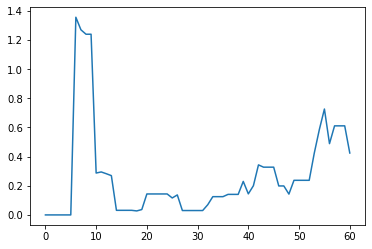

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.12961498942979305,
 'clustered_split_factor': 12,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd645184fd0>,
 'fit_shape': (141, 2),
 'split': 'state_device',
 'split_variance': 0.2320334799252437}


,sessions,rps
clust,,
0.0,1013,0.094492
1.0,2567,0.567982
2.0,4408,0.320898
3.0,2543,0.599439
4.0,2513,0.630657
5.0,9176,0.517742
6.0,3826,0.501454
7.0,1528,0.260844


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

state_clust     0
device_clust    0
utc_dt          0
dtype: int64

state_clust       88
device_clust       0
utc_dt          2901
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (3009, 11)
|--- x0_1.0 <= 0.50
|   |--- x0_3.0 <= 0.50
|   |   |--- x0_nan <= 0.50
|   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |   |--- x1_2.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.01]
|   |   |   |   |   |   |--- x1_2.0 >  0.50
|   |   |   |   |   |   |   |--- value: [0.08]
|   |   |   |   |   |--- x0_7.0 >  0.50
|   |   |   |   |   |   |--- x1_2.0 <= 0.50
|   |   |   |   |   |   |   |--- value: [0.22]
|   |   |   |   |   |   |--- x1_2.0 >  0.50
|   |   |   |   |   |   |   |--- value: [0.07]
|   |   |   |   |--- x1_0.0 >  0.50
|   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |  

,sessions,rps
clust,,
9,151,0.000000
10,50,0.919800
11,85,0.000000
12,125,0.046720
14,198,0.000000
15,116,0.106724
19,5317,0.629998
20,5157,0.531798
21,3139,0.500552


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.12738892329475132,
 'clustered_split_factor': 53,
 'clusterer': <__main__.AggRPSClust object at 0x7fd645a17c40>,
 'fit_shape': (370, 2),
 'split': 'state_os_device',
 'split_variance': 0.36387764301562653}


,sessions,rps
clust,,
0.0,2063,0.284159
1.0,63,0.000000
2.0,4391,0.665245
3.0,6635,0.501075
4.0,311,0.450032
5.0,2,0.000000
6.0,8223,0.535962
7.0,5688,0.306863


state               0
operating_system    0
device              0
utc_dt              0
dtype: int64

state               2682
operating_system     174
device               172
utc_dt              3951
dtype: int64

|X| (3951, 19)
|--- x0_TX <= 0.50
|   |--- x1_Windows <= 0.50
|   |   |--- x0_IL <= 0.50
|   |   |   |--- x1_Mac OS X <= 0.50
|   |   |   |   |--- x0_VA <= 0.50
|   |   |   |   |   |--- x2_PHON <= 0.50
|   |   |   |   |   |   |--- x0_nan <= 0.50
|   |   |   |   |   |   |   |--- x0_NY <= 0.50
|   |   |   |   |   |   |   |   |--- x2_nan <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.05]
|   |   |   |   |   |   |   |   |--- x2_nan >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.07]
|   |   |   |   |   |   |   |--- x0_NY >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.04]
|   |   |   |   |   |   |--- x0_nan >  0.50
|   |   |   |   |   |   |   |--- x2_DESK <= 0.50
|   |   |   |   |   |   |   |   |--- value: [0.06]
|   |   |   |   |   |   |   |--- x2_DESK >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.11]
|   |   |   |   |   |--- x2_PHON >  0.50
|   |   |   |   |   |   |--- x0_nan <= 0.50
|   |   |   |   |   |   |   |--- x1_nan <= 0.50
|   |   |   |   | 

,sessions,rps
clust,,
9,534,0.349644
11,32,0.000000
17,579,0.087945
22,67,0.000000
25,1105,0.225665
26,58,2.582241
28,80,0.000000
39,13732,0.472986
40,1174,0.634210


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


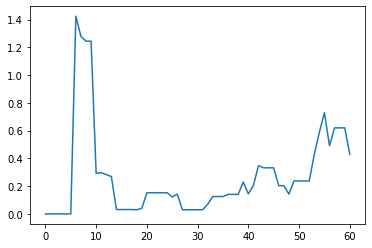

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.12955042963019867,
 'clustered_split_factor': 36,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd66dbd7460>,
 'fit_shape': (370, 2),
 'split': 'state_os_device',
 'split_variance': 0.36387764301562653}


,sessions,rps
clust,,
0.0,2393,0.299590
1.0,3724,0.538312
2.0,4111,0.301006
3.0,7677,0.567231
4.0,2493,0.637201
5.0,3134,0.428772
6.0,1471,0.275153
7.0,2373,0.621083


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

state_clust               0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

state_clust                  0
operating_system_clust      43
device_clust                 0
utc_dt                    2667
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (3951, 16)
|--- x0_3.0 <= 0.50
|   |--- x0_1.0 <= 0.50
|   |   |--- x1_3.0 <= 0.50
|   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |--- x1_2.0 <= 0.50
|   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |--- x2_1.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x2_0.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.07]
|   |   |   |   |   |   |   |   |--- x2_0.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |--- x0_0.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.10]
|   |   |   |   |   |   |--- x2_1.0 >  0.50
|   |   |   |   |   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.03]
|   |   |   |   |   |   |   |   | 

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (31, 2),
 'cluster_variance': 0.1586682557401939,
 'clustered_split_factor': 82,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd6465fc670>,
 'fit_shape': (370, 2),
 'split': 'state_os_device',
 'split_variance': 0.36387764301562653}


,sessions,rps
clust,,
9,59,0.098983
10,76,0.666447
11,81,0.083580
14,110,0.000000
16,109,0.000000
17,36,1.277500
18,30,0.000000
20,134,0.289328
21,148,0.000000


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.06178475769970573,
 'clustered_split_factor': 424,
 'clusterer': <__main__.AggRPSClust object at 0x7fd646d95580>,
 'fit_shape': (917, 2),
 'split': 'location_os',
 'split_variance': 0.6283189008052134}


,sessions,rps
clust,,
0.0,11685,0.422243
1.0,1,0.000000
2.0,345,0.335594
3.0,2,0.000000
4.0,11369,0.536513
5.0,97,0.059175
6.0,2,0.000000
7.0,3768,0.509547


state               0
dma                 0
operating_system    0
utc_dt              0
dtype: int64

state                827
dma                 9089
operating_system      43
utc_dt               278
dtype: int64

|X| (11211, 62)
|--- x0_TX <= 0.50
|   |--- x0_WY <= 0.50
|   |   |--- x2_Windows <= 0.50
|   |   |   |--- x0_WI <= 0.50
|   |   |   |   |--- x0_IL <= 0.50
|   |   |   |   |   |--- x0_CO <= 0.50
|   |   |   |   |   |   |--- x0_IN <= 0.50
|   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |--- x0_VA <= 0.50
|   |   |   |   |   |   |   |   |   |--- x2_Linux <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_MI <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- x0_MI >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.38]
|   |   |   |   |   |   |   |   |   |--- x2_Linux >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_CA <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- x0_CA >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.25]
|   |   |   |   |   |   |   |  

,sessions,rps
clust,,
16,732,0.264809
17,94,0.574149
27,75,0.165067
29,183,0.040164
31,84,0.000000
...,...,...
205,685,0.564599
207,110,0.968727
210,138,0.033696


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


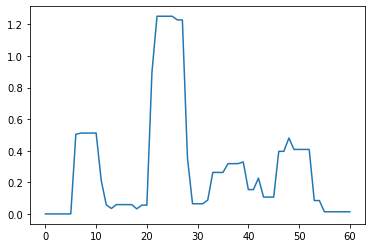

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.09423523944465816,
 'clustered_split_factor': 431,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd645050e20>,
 'fit_shape': (917, 2),
 'split': 'location_os',
 'split_variance': 0.6283189008052134}


,sessions,rps
clust,,
0.0,5225,0.385621
1.0,3180,0.562800
2.0,2709,0.385749
3.0,2685,0.453333
4.0,3048,0.658666
5.0,4529,0.408558
6.0,3715,0.503229
7.0,2178,0.588054


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

state_clust               0
dma_clust                 0
operating_system_clust    0
utc_dt                    0
dtype: int64

state_clust                 0
dma_clust                   0
operating_system_clust     43
utc_dt                    278
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (11211, 21)
|--- x1_0.0 <= 0.50
|   |--- x0_3.0 <= 0.50
|   |   |--- x2_3.0 <= 0.50
|   |   |   |--- x1_2.0 <= 0.50
|   |   |   |   |--- x2_1.0 <= 0.50
|   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |--- x2_4.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_7.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.17]
|   |   |   |   |   |   |   |   |--- x1_7.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.19]
|   |   |   |   |   |   |   |   |   |--- x0_5.0 

{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (92, 2),
 'cluster_variance': 0.24432179976128143,
 'clustered_split_factor': 609,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd6466fa7c0>,
 'fit_shape': (917, 2),
 'split': 'location_os',
 'split_variance': 0.6283189008052134}


,sessions,rps
clust,,
12,152,0.371118
13,52,0.000000
15,45,0.156222
16,107,0.990374
17,54,0.000000
...,...,...
178,104,0.668269
179,448,0.859464
180,573,0.224747


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.06925542551445571,
 'clustered_split_factor': 314,
 'clusterer': <__main__.AggRPSClust object at 0x7fd66d75db80>,
 'fit_shape': (625, 2),
 'split': 'location_device',
 'split_variance': 0.5046026768729098}


,sessions,rps
clust,,
0.0,8308,0.414463
1.0,2,0.000000
2.0,295,0.417186
3.0,2,0.000000
4.0,6471,0.586632
5.0,51,0.112549
6.0,8641,0.447400
7.0,3697,0.514529


state     0
dma       0
device    0
utc_dt    0
dtype: int64

state     1142
dma       9165
device       0
utc_dt     270
dtype: int64

|X| (10118, 47)
|--- x0_TX <= 0.50
|   |--- x0_WY <= 0.50
|   |   |--- x0_NY <= 0.50
|   |   |   |--- x0_VA <= 0.50
|   |   |   |   |--- x1_511 <= 0.50
|   |   |   |   |   |--- x0_IL <= 0.50
|   |   |   |   |   |   |--- x2_DESK <= 0.50
|   |   |   |   |   |   |   |--- x0_WI <= 0.50
|   |   |   |   |   |   |   |   |--- x0_PA <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_nan <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- x0_nan >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.09]
|   |   |   |   |   |   |   |   |   |--- x0_GA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.24]
|   |   |   |   |   |   |   |   |--- x0_PA >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.27]
|   |   |   |   |   |   |   |--- x0_WI >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.96]
|   |   |   |   |   |   |--- x2_D

,sessions,rps
clust,,
18,226,0.225310
19,61,0.000000
20,142,0.000000
21,26,0.224615
22,48,0.000000
23,61,0.000000
24,32,0.000000
25,70,0.260000
27,58,0.144483


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


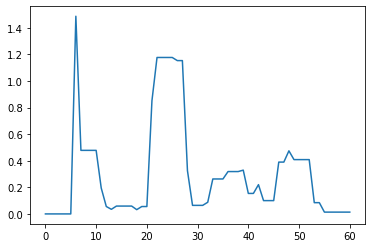

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.08900273997086129,
 'clustered_split_factor': 309,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd66d75d400>,
 'fit_shape': (625, 2),
 'split': 'location_device',
 'split_variance': 0.5046026768729098}


,sessions,rps
clust,,
0.0,3513,0.494414
1.0,4421,0.390111
2.0,2479,0.597545
3.0,2848,0.389940
4.0,2092,0.435531
5.0,3217,0.639112
6.0,4148,0.530289
7.0,4749,0.403506


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

state_clust     0
dma_clust       0
device_clust    0
utc_dt          0
dtype: int64

state_clust       0
dma_clust         0
device_clust      0
utc_dt          270
dtype: int64

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (10118, 19)
|--- x1_1.0 <= 0.50
|   |--- x0_2.0 <= 0.50
|   |   |--- x1_7.0 <= 0.50
|   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |--- x2_0.0 <= 0.50
|   |   |   |   |   |   |--- x0_3.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_5.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_6.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |   |--- x0_7.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.06]
|   |   |   |   |   |   |   |   |--- x1_6.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.06]
|   |   |   |   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.13]
|   |   |   |   |   |   |   |--- x1_5.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.22]
|   |   |   |   |   |   |--- x0_3.0 >  0.50
|   |

,sessions,rps
clust,,
10,84,0.000000
11,73,0.138493
13,17,0.000000
14,27,0.000000
15,108,0.000000
...,...,...
130,590,0.242525
131,446,0.411659
132,485,0.725505


<ipython-input-140-8f2b8b24211e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.061313098992303805,
 'clustered_split_factor': 647,
 'clusterer': <__main__.AggRPSClust object at 0x7fd6470b57f0>,
 'fit_shape': (1145, 2),
 'split': 'location_os_device',
 'split_variance': 0.6626215498302633}


,sessions,rps
clust,,
0.0,11535,0.426819
1.0,1,0.000000
2.0,345,0.335594
4.0,104,0.055192
5.0,11326,0.538550
6.0,2,0.000000
7.0,3750,0.511993


state               0
dma                 0
operating_system    0
device              0
utc_dt              0
dtype: int64

state                832
dma                 8951
operating_system      43
device                 0
utc_dt               280
dtype: int64

|X| (11334, 67)
|--- x0_TX <= 0.50
|   |--- x0_WY <= 0.50
|   |   |--- x2_Windows <= 0.50
|   |   |   |--- x0_WI <= 0.50
|   |   |   |   |--- x0_IL <= 0.50
|   |   |   |   |   |--- x1_524 <= 0.50
|   |   |   |   |   |   |--- x0_CO <= 0.50
|   |   |   |   |   |   |   |--- x0_IN <= 0.50
|   |   |   |   |   |   |   |   |--- x1_508 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_VA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x2_Linux <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- x2_Linux >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |--- x0_VA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x3_PHON <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |   |   |--- x3_PHON >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.59]
|   |   |   |   |   |   |

,sessions,rps
clust,,
16,833,0.241525
17,95,0.568105
18,64,0.193437
31,180,0.000000
33,86,0.000000
...,...,...
209,110,0.968727
213,55,0.084545
214,83,0.000000


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


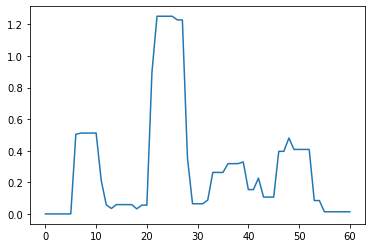

<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.09413683989303029,
 'clustered_split_factor': 644,
 'clusterer': <__main__.KpiCorrClust object at 0x7fd647022e50>,
 'fit_shape': (1145, 2),
 'split': 'location_os_device',
 'split_variance': 0.6626215498302633}


,sessions,rps
clust,,
0.0,1406,0.490122
1.0,5441,0.397377
2.0,2198,0.501255
3.0,3612,0.521022
4.0,3046,0.659099
5.0,3170,0.605315
6.0,5288,0.402428
7.0,2902,0.404906


<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-140-8f2b8b24211e>:129: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-140-8f2b8b24211e>:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-141-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will 

state_clust               0
dma_clust                 0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

state_clust                 0
dma_clust                   0
operating_system_clust     43
device_clust                0
utc_dt                    280
dtype: int64

|X| (11334, 24)
|--- x1_0.0 <= 0.50
|   |--- x0_4.0 <= 0.50
|   |   |--- x1_3.0 <= 0.50
|   |   |   |--- x2_3.0 <= 0.50
|   |   |   |   |--- x1_7.0 <= 0.50
|   |   |   |   |   |--- x0_7.0 <= 0.50
|   |   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |   |--- x2_4.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_6.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x2_1.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- x0_0.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.23]
|   |   |   |   |   |   |   |   |   |--- x2_1.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   | 

<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-140-8f2b8b24211e>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (99, 2),
 'cluster_variance': 0.23279109600653924,
 'clustered_split_factor': 933,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fd6462c14f0>,
 'fit_shape': (1145, 2),
 'split': 'location_os_device',
 'split_variance': 0.6626215498302633}


,sessions,rps
clust,,
14,59,1.796102
15,91,0.000000
16,77,0.079481
17,58,0.066034
18,26,0.000000
...,...,...
192,264,0.304886
193,382,0.797408
194,224,0.277679


,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor
0,AggRPSClust,<__main__.AggRPSClust object at 0x7fd66e290bb0>,browser,"(2, 2)","(2, 2)",0.007595,0.007595,2
1,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd644f3a5e0>,browser,"(2, 2)","(1, 2)",0.007595,0.000000,1
2,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd644f3a130>,browser,"(2, 2)","(2, 2)",0.007595,0.007595,2
3,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,browser,"(2, 2)","(1, 2)",0.007595,0.000000,1
4,AggRPSClust,<__main__.AggRPSClust object at 0x7fd64541fa90>,operating_system,"(6, 2)","(6, 2)",0.076661,0.076661,6
...,...,...,...,...,...,...,...,...
63,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,location_device,"(625, 2)","(68, 2)",0.504603,0.198574,404
64,AggRPSClust,<__main__.AggRPSClust object at 0x7fd6470b57f0>,location_os_device,"(1145, 2)","(7, 2)",0.662622,0.061313,647
65,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd646046790>,location_os_device,"(1145, 2)","(84, 2)",0.662622,0.250917,485
66,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd647022e50>,location_os_device,"(1145, 2)","(8, 2)",0.662622,0.094137,644


In [141]:
perfD = []
for split,rps_df in split2aggrps.items():
    
    rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
    rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
    rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
    rps_df["rps"] = rps_df["rps_avg"]
    fitI = rps_df.reset_index()['utc_dt'] < eval_date
    fitI.index = rps_df.index

    for clust_mtd in [AggRPSClust,TreeRPSClust,KpiCorrClust,HybridCorrTreeClust]:
        clusterer = clust_mtd().fit(rps_df[fitI],None)
        rps_df["clust"] = -1
        rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
        rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

        agg_rps_df = rps_df \
            [~fitI] \
            .groupby(rps_df.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })
        clust_rps_df = rps_df \
            [~fitI] \
            .groupby("clust") \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })

        assert clust_rps_df["rps"].max() <= agg_rps_df["rps"].max()
        rps_wavg = wavg(agg_rps_df[["rps"]], agg_rps_df["sessions"])
        rps_clust_wavg = wavg(clust_rps_df[["rps"]], clust_rps_df["sessions"])
        assert all((rps_wavg - rps_clust_wavg).abs() < 1e-2), (rps_wavg, rps_clust_wavg)


        perfd = {
            "clust_mtd": clusterer.__class__.__name__,
            "clusterer": clusterer,
            "split": split,
            "fit_shape": agg_rps_df.shape,
            "clust_shape": clust_rps_df.shape,
            "split_variance": wstd(agg_rps_df["rps"], agg_rps_df["sessions"]),
            "cluster_variance": wstd(clust_rps_df["rps"], clust_rps_df["sessions"]),
            # wstd(rps_df["rps_avg"],rps_df["sessions"])
            "clustered_split_factor": get_split_factor(rps_df),
        }
        perfD.append(perfd)
        pprint.pprint(perfd)
        ipydisp(clust_rps_df)

perfdf = pd.DataFrame(perfD)
ipydisp(perfdf)

In [142]:
clusterer.tree_clusterer.min_samples_leaf

30

In [143]:
perfdf.tail(50)

,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor
18,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd66e1d41f0>,TOD,"(553, 2)","(8, 2)",0.353484,0.052862,46
19,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,TOD,"(553, 2)","(49, 2)",0.353484,0.144971,54
20,AggRPSClust,<__main__.AggRPSClust object at 0x7fd64541f430>,dma,"(209, 2)","(8, 2)",0.319783,0.068929,8
21,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd6477d7c10>,dma,"(209, 2)","(1, 2)",0.319783,0.000000,1
22,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd6477d7af0>,dma,"(209, 2)","(8, 2)",0.319783,0.077347,8
23,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,dma,"(209, 2)","(8, 2)",0.319783,0.074957,8
24,AggRPSClust,<__main__.AggRPSClust object at 0x7fd646301c10>,state,"(51, 2)","(8, 2)",0.194878,0.116217,8
25,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fd654274cd0>,state,"(51, 2)","(1, 2)",0.194878,0.000000,1
26,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fd6468b2730>,state,"(51, 2)","(8, 2)",0.194878,0.098902,8
27,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fd6...,state,"(51, 2)","(7, 2)",0.194878,0.097983,7


In [242]:
split,clusterer = perfdf.loc[27,["split","clusterer"]]
print("split:",split)
rps_df = split2aggrps[split]
rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df["rps"] = rps_df["rps_avg"]
fitI = rps_df.reset_index()['utc_dt'] < eval_date
fitI.index = rps_df.index

rps_df["clust"] = -1
rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

split_attr2unique_vals = {index_col: rps_df.index.unique(index_col) 
                          for index_col in rps_df.index.names[:-1]}
_,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
rps_df = rps_df.reset_index()
campaign_df = rps_df \
    .groupby([*new_index_order[:-1], "clust"]) \
    .agg({
        "sessions": sum,
        "rps_avg": get_wavg_by(rps_df,"sessions"),
        new_index_order[-1]: lambda seq: tuple(set(seq))
    }) \
    .sort_index()

assert campaign_df["sessions"].sum() == rps_df["sessions"].sum()
camp_rps_wavg = wavg(campaign_df["rps_avg"],campaign_df["sessions"])
fit_rps_wavg = wavg(rps_df["rps_avg"], rps_df["sessions"])
assert abs(camp_rps_wavg - fit_rps_wavg) < 1e-5

|X| (4176, 19)
|X| (2227, 19)


In [246]:
camps = []
for idx,r in campaign_df.iterrows():
    camp = {
        "sessions_60d": r["sessions"], 
        "rps_avg_60d": r["rps_avg"]
    }
    for field,val in zip(new_index_order[:-1],idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "INCLUDE": r[last_field]
    }
    camps.append(camp)

excl_campaign_df = campaign_df.groupby([*new_index_order[:-1]]) \
    .agg({
        new_index_order[-1]: tuple
    })
def flatten(M):
    return tuple(el for r in M for el in r)
excl_campaign_df[new_index_order[-1]] = excl_campaign_df[new_index_order[-1]] \
    .apply(flatten)
for idx, r in excl_campaign_df.iterrows():
    camp = {}
    for field, val in zip(new_index_order[:-1], idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "EXCLUDE": r[last_field]
    }
    camps.append(camp)

camp_attr_df = pd.DataFrame(camps)
camp_attr_df.to_csv("campaign_dump.csv")
camp_attr_df

,sessions_60d,rps_avg_60d,device,operating_system,state
0,9.0,0.000000,{'INCLUDE': 'DESK'},{'INCLUDE': 'Android'},"{'INCLUDE': ('NY', 'FL', 'CA')}"
1,1.0,0.000000,{'INCLUDE': 'DESK'},{'INCLUDE': 'Android'},"{'INCLUDE': ('VA',)}"
2,2.0,0.000000,{'INCLUDE': 'DESK'},{'INCLUDE': 'Android'},"{'INCLUDE': ('TX',)}"
3,535.0,0.340172,{'INCLUDE': 'DESK'},{'INCLUDE': 'Linux'},"{'INCLUDE': ('OK', 'PA', 'AZ', 'RI', 'MN', 'ND..."
4,161.0,0.036894,{'INCLUDE': 'DESK'},{'INCLUDE': 'Linux'},"{'INCLUDE': ('NY',)}"
...,...,...,...,...,...
80,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'Linux'},"{'EXCLUDE': ('OK', 'PA', 'AZ', 'RI', 'MN', 'ND..."
81,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'Mac OS X'},"{'EXCLUDE': ('OK', 'PA', 'NJ', 'MI', 'DE', 'MD..."
82,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'Windows'},"{'EXCLUDE': ('AZ', 'DC', 'WA', 'OH', 'GA', 'NC')}"
83,NaN,NaN,{'INCLUDE': 'TBLT'},{'INCLUDE': 'iOS'},"{'EXCLUDE': ('WI', 'OH', 'TX')}"


In [147]:
import json

TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

from pytaboola.services import AccountService
from pytaboola.services import CampaignService

import itertools
import tqdm
import pandas as pd
import os
from pkg_resources import resource_filename as rscfn


acct_service = AccountService(client)
accnts = acct_service.list()["results"]
NETWORK_ACCNT_ID = "healthcareinc-network"
TEST_ACCNT_ID = "healthcareinc-sc2"
O65_ACCNT_ID = "taboolaaccount-rangaritahealthcarecom"
id2accnt = {a["account_id"]: a for a in accnts}

def accnt_camps(accnt):
    camp_service = CampaignService(client, accnt["account_id"])
    return camp_service.list()
aid2cid2camp = {}
for aid,a in tqdm.tqdm(id2accnt.items()):
    cid2camp = {c["id"]: c for c in accnt_camps(a)}
    aid2cid2camp[aid] = cid2camp

import json
json.dump(aid2cid2camp, open("camps.json", "w"))
O65_accnt_camps = accnt_camps(id2accnt[O65_ACCNT_ID])
print("|065_accnt_camps|:",len(O65_accnt_camps))

test_accnt_camps = accnt_camps(id2accnt[TEST_ACCNT_ID])
print("|test_accnt_camps|",len(test_accnt_camps))

import itertools
cross = itertools.product
import jmespath
get = jmespath.search

active_camps = get(
  "*.*[] | [?is_active]",
  aid2cid2camp,
)
print("|active campaigns|:",len(active_camps))

100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


|065_accnt_camps|: 100


In [261]:
def taboola_targetting_fields(r):
    def pivot(o):
        (t,v),*_ = o.items()
        return {
            "type": t,
            "value": [*v] if isinstance(v,(list,tuple,set)) else [v]
        }
    targetting_fields = {}
    if "device" in r:
        targetting_fields["platform_targeting"] = pivot(r["device"])
    if "state" in r:
        targetting_fields["sub_country_targeting"] = pivot(r["state"])
    if "dma" in r:
        targetting_fields["dma_country_targeting"] = pivot(r["dma"])
    if "operating_system" in r:
        (t,v),*_ = r["operating_system"].items()
        targetting_fields["os_targeting"] = {
            "type": "INCLUDE",
            "value": [
                {
                    "os_family": v
                },
            ],
        }
    return targetting_fields
ipydisp(camp_attr_df.apply(taboola_targetting_fields,axis=1).head())
taboola_targetting_fields(camp_attr_df.iloc[0,:])

0    {'platform_targeting': {'type': 'INCLUDE', 'va...
1    {'platform_targeting': {'type': 'INCLUDE', 'va...
2    {'platform_targeting': {'type': 'INCLUDE', 'va...
3    {'platform_targeting': {'type': 'INCLUDE', 'va...
4    {'platform_targeting': {'type': 'INCLUDE', 'va...
dtype: object

{'platform_targeting': {'type': 'INCLUDE', 'value': ['DESK']},
 'sub_country_targeting': {'type': 'INCLUDE', 'value': ['NY', 'FL', 'CA']},
 'os_targeting': {'type': 'INCLUDE', 'value': [{'os_family': 'Android'}]}}

In [269]:
src_accnt = id2accnt[O65_ACCNT_ID]
src_camp = active_camps[0]
dest_accnt = id2accnt[TEST_ACCNT_ID]

client = TaboolaClient(**TABOOLA_HC_CREDS)
client.authorization_header,client.token_details

resp = requests.post(
    f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
    json={
        "name": src_camp["id"],
        "start_date": (TODAY + 2*DAY).__str__(),
        **taboola_targetting_fields(camp_attr_df.iloc[0]),
    },
    params= {
        "destination_account": dest_accnt["account_id"],
    },
    headers=client.authorization_header,)
resp.raise_for_status()

new_camp = resp.json()

HTTPError: 400 Client Error: Bad Request for url: https://backstage.taboola.com/backstage/api/1.0/taboolaaccount-rangaritahealthcarecom/campaigns/10798231/duplicate?destination_account=healthcareinc-sc2

In [ ]:
# import requests
# TODAY = NOW.date()
# TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
# for src_camp in active_camps:
#     src_accnt = id2accnt[O65_ACCNT_ID]
#     dest_accnt = id2accnt[TEST_ACCNT_ID]

#     client = TaboolaClient(**TABOOLA_HC_CREDS)
#     client.authorization_header,client.token_details

#     for _,camp_attrs in camp_attr_df.iterrows():
#         resp = requests.post(
#             f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
#             json={
#                 "name": src_camp["id"],
#                 "start_date": (TODAY + 2*DAY).__str__(),
#                 **taboola_targetting_fields(camp_attrs),
#             },
#             params= {
#                 "destination_account": dest_accnt["account_id"],
#             },
#             headers=client.authorization_header,)
#         resp.raise_for_status()

#         new_camp = resp.json()

In [165]:
import json
TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

import requests
import jmespath
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/operating_systems",
    headers=client.authorization_header)
taboola_os = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/platforms",
    headers=client.authorization_header)
taboola_platforms = jmespath.search('results[].name', resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/dma",
    headers=client.authorization_header)
taboola_dmas = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/regions",
    headers=client.authorization_header)
taboola_states = jmespath.search('results[].name',resp.json(),)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.feature_selection
import sklearn.metrics
from matplotlib import pyplot as plt
import sklearn.preprocessing

requires_campaign_split = [
    # "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]

for split in requires_campaign_split:
    rps_df = split2aggrps[split] .reset_index()
    Xs = rps_df \
        .apply(lambda r: [r["int_ix"]]*int(r["sessions"]), axis=1)
    X = np.concatenate(Xs.values).reshape(-1,1)
    ys = rps_df \
        .apply(lambda r: [r["rps_avg"]]*int(r["sessions"]),axis=1)
    y = np.concatenate(ys.values)
    # print(y.min(),np.quantile(y, 0.5),y.max())
    y = y > y.mean()
    # y = np.concatenate(ys.values).reshape(-1,1)
    # y = sklearn.preprocessing.KBinsDiscretizer(n_bins=2,encode="ordinal") \
    #     .fit_transform(y).reshape(-1)
    mi = sklearn.feature_selection.mutual_info_regression(X,y,discrete_features=True)
    print(split,mi,y.mean(),rps_df.shape)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]
combined_rps_df = pd.concat([df.reset_index() for df in split2aggrps.values()])
splitI = combined_rps_df["split_on"].isin(requires_campaign_split)
density = scipy.stats.gaussian_kde(
    dataset=combined_rps_df.loc[splitI,"rps_avg"],
    weights=combined_rps_df.loc[splitI, "sessions"],
    # bw_method="scott",
    # bw_method="silverman",
    # bw_method=0.1,
)
xs = np.linspace(0,2,100)
plt.plot(xs,density(xs))

In [ ]:
for split in requires_campaign_split:
    splitI = combined_rps_df["split_on"] == split
    density = scipy.stats.gaussian_kde(
        dataset=combined_rps_df.loc[splitI, "rps_avg"],
        weights=combined_rps_df.loc[splitI, "sessions"])
    xs = np.linspace(0, 2, 100)
    plt.plot(xs, density(xs))
    plt.title(split)
    plt.show()